In [3]:
import cv2
import os
import numpy as np
#from keras.models import load_model

In [4]:
data_path = 'D:/DS/Face Mask Detection/data'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels)) #empty dictionary

print(label_dict)
print('\n')
print('The categories are : ',categories)
print('\n')
print('The labels are : ',labels)

{'without_mask': 0, 'with_mask': 1}


The categories are :  ['without_mask', 'with_mask']


The labels are :  [0, 1]


In [5]:
img_size = 100
data = []
target = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray,(img_size, img_size))
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:', e)
            

In [6]:
data = np.array(data)/255.0
data= np.reshape(data,(data.shape[0], img_size, img_size, 1))
target = np.array(target)



In [7]:
from keras.utils import np_utils
new_target = np_utils.to_categorical(target)

In [8]:
np.save('datav', data)
np.save('targetv', new_target)

In [9]:
datav = np.load('datav.npy')
targetv = np.load('targetv.npy')

In [10]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [11]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=datav.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(2,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(datav,targetv,test_size=0.1)

In [13]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=10,callbacks=[checkpoint],validation_split=0.2)

Train on 990 samples, validate on 248 samples
Epoch 1/10
990/990 [==============================] - 71s 72ms/step - loss: 0.7414 - accuracy: 0.5273 - val_loss: 0.6942 - val_accuracy: 0.5081
Epoch 2/10
990/990 [==============================] - 69s 69ms/step - loss: 0.6175 - accuracy: 0.6444 - val_loss: 0.5094 - val_accuracy: 0.7137
Epoch 3/10
990/990 [==============================] - 69s 69ms/step - loss: 0.4491 - accuracy: 0.7949 - val_loss: 0.4335 - val_accuracy: 0.8508
Epoch 4/10
990/990 [==============================] - 70s 71ms/step - loss: 0.3301 - accuracy: 0.8727 - val_loss: 0.3087 - val_accuracy: 0.8750
Epoch 5/10
990/990 [==============================] - 67s 67ms/step - loss: 0.2039 - accuracy: 0.9283 - val_loss: 0.2607 - val_accuracy: 0.9153
Epoch 6/10
990/990 [==============================] - 66s 66ms/step - loss: 0.1698 - accuracy: 0.9424 - val_loss: 0.2684 - val_accuracy: 0.9032
Epoch 7/10
990/990 [==============================] - 66s 66ms/step - loss: 0.1524 - accur

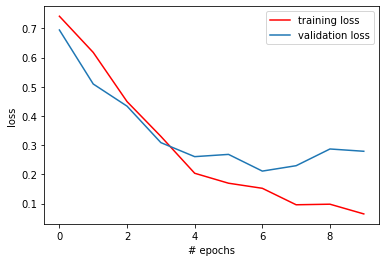

In [14]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

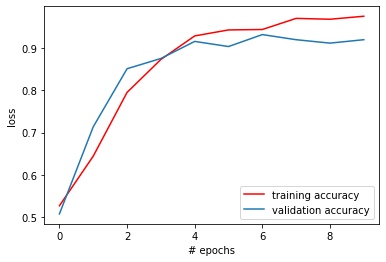

In [15]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
model = load_model('model-009.model')

face_clsfr=cv2.CascadeClassifier('D:/DS/Face Mask Detection/haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={1:'MASK',0:'NO MASK'}
color_dict={1:(0,255,0),0:(0,0,255)}

In [30]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()